#**Import Necessary Libraries**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import pairwise_distances
import numpy as np
from cvxpy import Variable, Minimize, Problem, norm, sum_squares
from scipy.spatial import ConvexHull

# **Load the dataset**

In [ ]:
file_path = '/content/Estimated Area By Size Class And Land Use.csv'  # Update with the correct file path
df = pd.read_csv(file_path)

#**Step 1: Explore the Data**

In [ ]:
# Display the first 10 rows of the dataset
df.head(10)

# Display information about the dataset
print(df.info())

# Display summary statistics
print(df.describe())

# Check the shape of the dataset
df.shape

# Select a subset of columns for initial exploration
ilocfunc = df.iloc[:,0:9]
ilocfunc

<class 'pandas.core.frame.DataFrame'>
Index: 28360 entries, 0 to 29959
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ROWID                       28360 non-null  int64  
 1   Country                     28360 non-null  object 
 2   State lgd code              28360 non-null  int64  
 3   State                       28360 non-null  object 
 4   District lgd code           28360 non-null  int64  
 5   District                    28360 non-null  object 
 6   YearCode                    28360 non-null  int64  
 7   Year                        28360 non-null  object 
 8   Social group type           28360 non-null  object 
 9   Land area size              28360 non-null  object 
 10  Category of holdings        28360 non-null  object 
 11  Net area sown               28360 non-null  float64
 12  Area under current fallows  28360 non-null  float64
 13  Net area cultivated         28360 no

,ROWID,Country,State lgd code,State,District lgd code,District,YearCode,Year,Social group type
0,1,India,1,Jammu And Kashmir,1,Anantnag,2015,"Agriculture Year (Jul - Jun), 2015",Institutional
1,2,India,1,Jammu And Kashmir,1,Anantnag,2015,"Agriculture Year (Jul - Jun), 2015",Institutional
2,3,India,1,Jammu And Kashmir,1,Anantnag,2015,"Agriculture Year (Jul - Jun), 2015",Institutional
3,4,India,1,Jammu And Kashmir,1,Anantnag,2015,"Agriculture Year (Jul - Jun), 2015",Institutional
4,5,India,1,Jammu And Kashmir,1,Anantnag,2015,"Agriculture Year (Jul - Jun), 2015",Institutional
...,...,...,...,...,...,...,...,...,...
29955,29956,India,38,The Dadra And Nagar Haveli And Daman And Diu,465,Dadra And Nagar Haveli,2015,"Agriculture Year (Jul - Jun), 2015",Scheduled Tribes
29956,29957,India,38,The Dadra And Nagar Haveli And Daman And Diu,465,Dadra And Nagar Haveli,2015,"Agriculture Year (Jul - Jun), 2015",Scheduled Tribes
29957,29958,India,38,The Dadra And Nagar Haveli And Daman And Diu,465,Dadra And Nagar Haveli,2015,"Agriculture Year (Jul - Jun), 2015",Scheduled Tribes
29958,29959,India,38,The Dadra And Nagar Haveli And Daman And Diu,465,Dadra And Nagar Haveli,2015,"Agriculture Year (Jul - Jun), 2015",Scheduled Tribes


# **Step 2: Data Cleaning**

### 2.1: Remove any trailing spaces in column names

In [ ]:
df.columns = df.columns.str.strip()

### 2.2: Handle missing values (drop rows with any null values)

In [ ]:
df.dropna(inplace=True)

### 2.3: Remove duplicates if any

In [ ]:
df.drop_duplicates(inplace=True)

### 2.4: Ensure correct data types

In [ ]:
# Convert numeric columns to appropriate data types if they are not already
numeric_cols = ['Net area sown', 'Area under current fallows', 'Net area cultivated', 'Uncultivated area']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

### 2.5: Handle incorrect or outlier data (e.g., negative values)

In [ ]:
df = df[(df[numeric_cols] >= 0).all(axis=1)]

# **Step 3: Market Segmentation**

In [ ]:
# Group data by State
state_agg = df.groupby(['State']).agg({
    'Net area sown': 'sum',
    'Area under current fallows': 'sum',
    'Net area cultivated': 'sum',
    'Uncultivated area': 'sum'
}).reset_index()

# Group data by State, District, Land area size, and Category of holdings
segmentation = df.groupby(['State', 'District', 'Land area size', 'Category of holdings']).agg({
    'Net area sown': 'sum',
    'Area under current fallows': 'sum',
    'Net area cultivated': 'sum',
    'Uncultivated area': 'sum'
}).reset_index()

# **Step 4: Data Visualization**

### 4.1: Bar Plot for Land Holdings by Category

<ipython-input-19-061a344d0aee>:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Category of holdings', y='Net area cultivated', data=segmentation, ci=None)


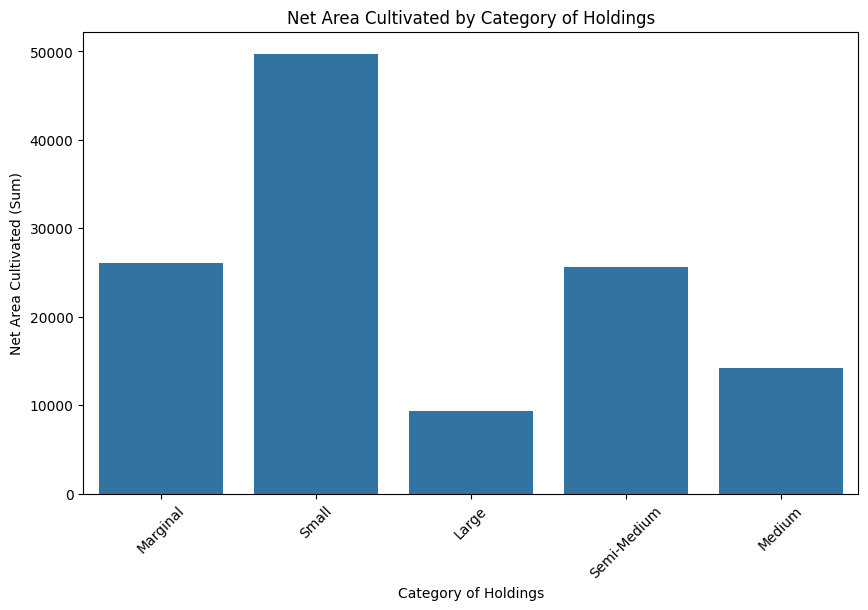

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Category of holdings', y='Net area cultivated', data=segmentation, ci=None)
plt.title('Net Area Cultivated by Category of Holdings')
plt.ylabel('Net Area Cultivated (Sum)')
plt.xlabel('Category of Holdings')
plt.xticks(rotation=45)
plt.show()

###4.2: Heatmap Visualization of Land Usage by State

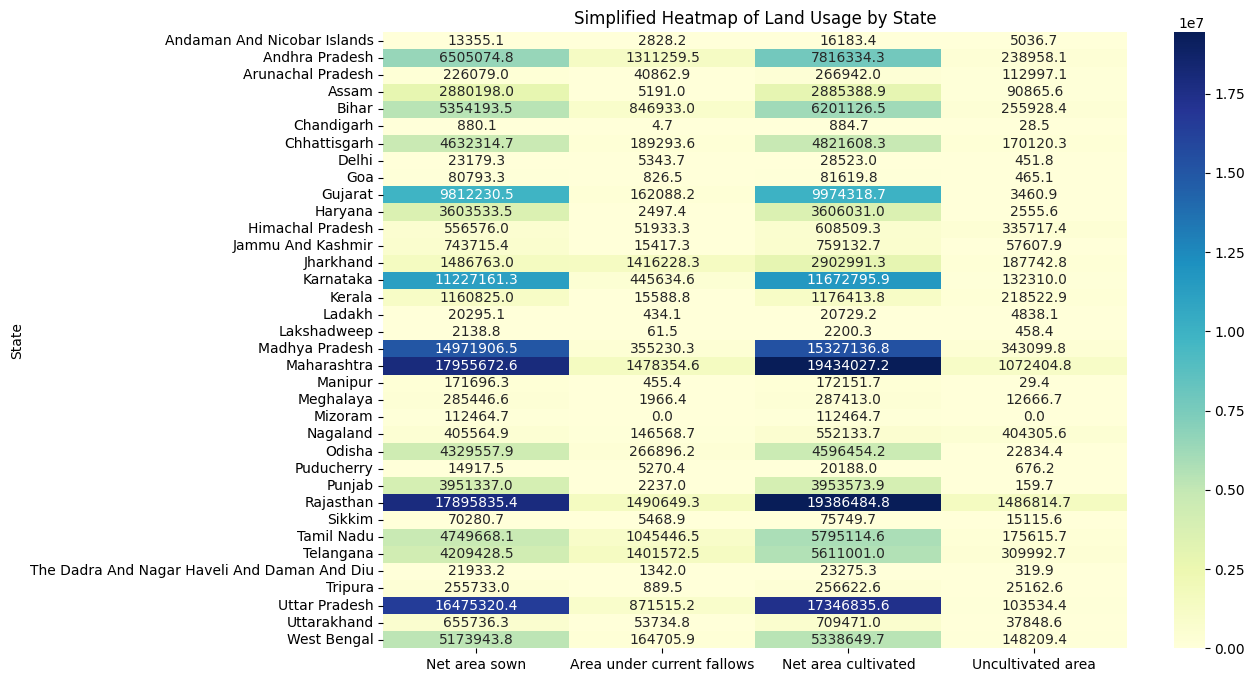

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(state_agg.set_index('State'), annot=True, fmt=".1f", cmap='YlGnBu')
plt.title('Simplified Heatmap of Land Usage by State')
plt.ylabel('State')
plt.show()

###4.3: Pie Chart Visualization for Land Distribution

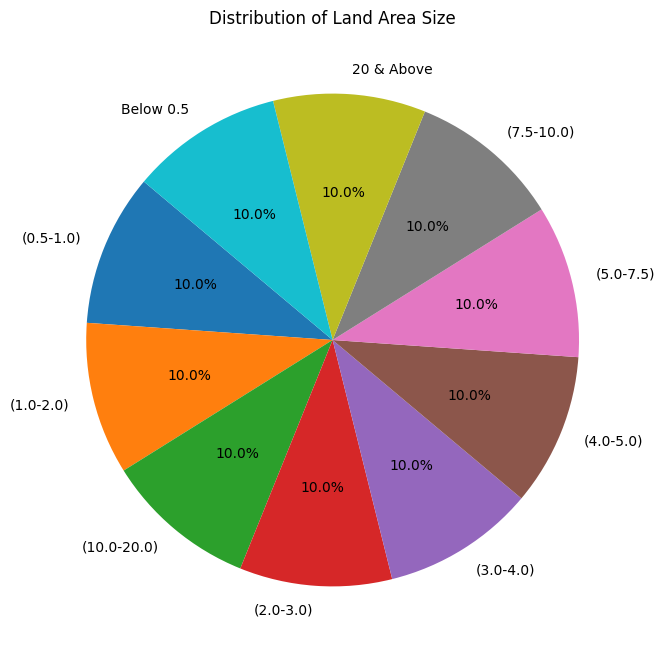

In [ ]:
plt.figure(figsize=(8, 8))
segmentation['Land area size'].value_counts().plot.pie(autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Land Area Size')
plt.ylabel('')
plt.show()

# **Step 5: K-Means Clustering**

### 5.1: Normalize the data

In [ ]:
scaler = StandardScaler()
state_agg_scaled = scaler.fit_transform(state_agg.iloc[:, 1:])

### 5.2: Applying K-Means Clustering

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42)  # Change number of clusters as needed
state_agg['Cluster'] = kmeans.fit_predict(state_agg_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


# **Step 6: Visualize Clusters**

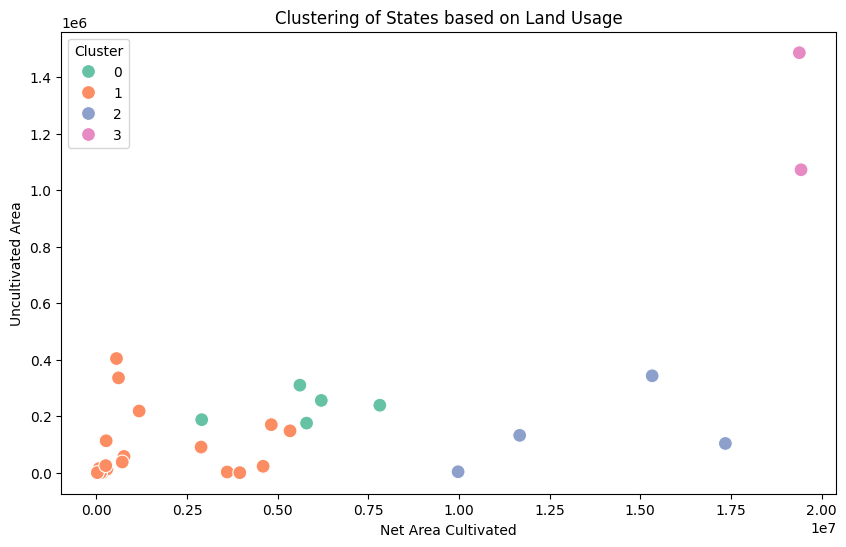

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=state_agg['Net area cultivated'], y=state_agg['Uncultivated area'], hue=state_agg['Cluster'], palette='Set2', s=100)
plt.title('Clustering of States based on Land Usage')
plt.xlabel('Net Area Cultivated')
plt.ylabel('Uncultivated Area')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

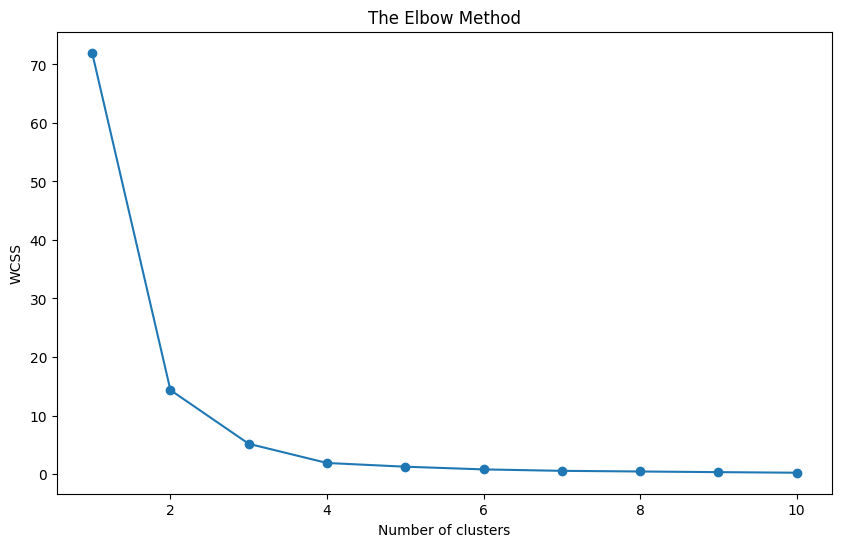

In [ ]:
numeric_data = state_agg.iloc[:, 1:]  # Exclude 'State' column

# Normalizing the data
scaler = StandardScaler()
state_agg_scaled = scaler.fit_transform(numeric_data)

# Extracting relevant features for clustering
X = state_agg_scaled[:, [0, 2]]  # Using 'Net area sown' and 'Net area cultivated' as example features

# Using the elbow method to find the optimal number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plotting the Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


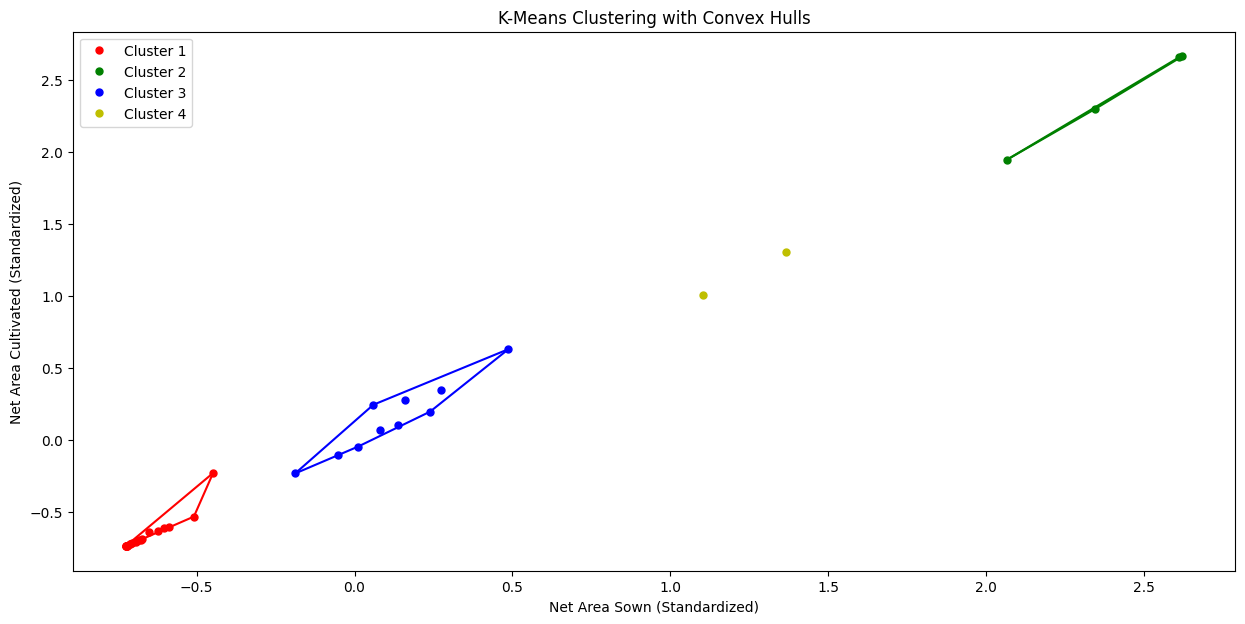

In [ ]:
# From the Elbow Method, determine the optimal number of clusters (let's assume it's 4)
optimal_clusters = 4  # You may change this based on the elbow plot

# Applying K-Means with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', random_state=42)
y_kmeans = kmeans.fit_predict(X)

# Visualizing the clusters using Convex Hulls
plt.figure(figsize=(15, 7))
colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k']
for i in range(optimal_clusters):
    points = X[y_kmeans == i]
    if len(points) >= 3:  # ConvexHull requires at least 3 points
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1], colors[i] + '-')
    plt.plot(points[:, 0], points[:, 1], 'o', markersize=5, color=colors[i], label=f'Cluster {i+1}')

# Plot settings
plt.title('K-Means Clustering with Convex Hulls')
plt.xlabel('Net Area Sown (Standardized)')
plt.ylabel('Net Area Cultivated (Standardized)')
plt.legend()
plt.show()

#**Step 7: Convex Clustering**

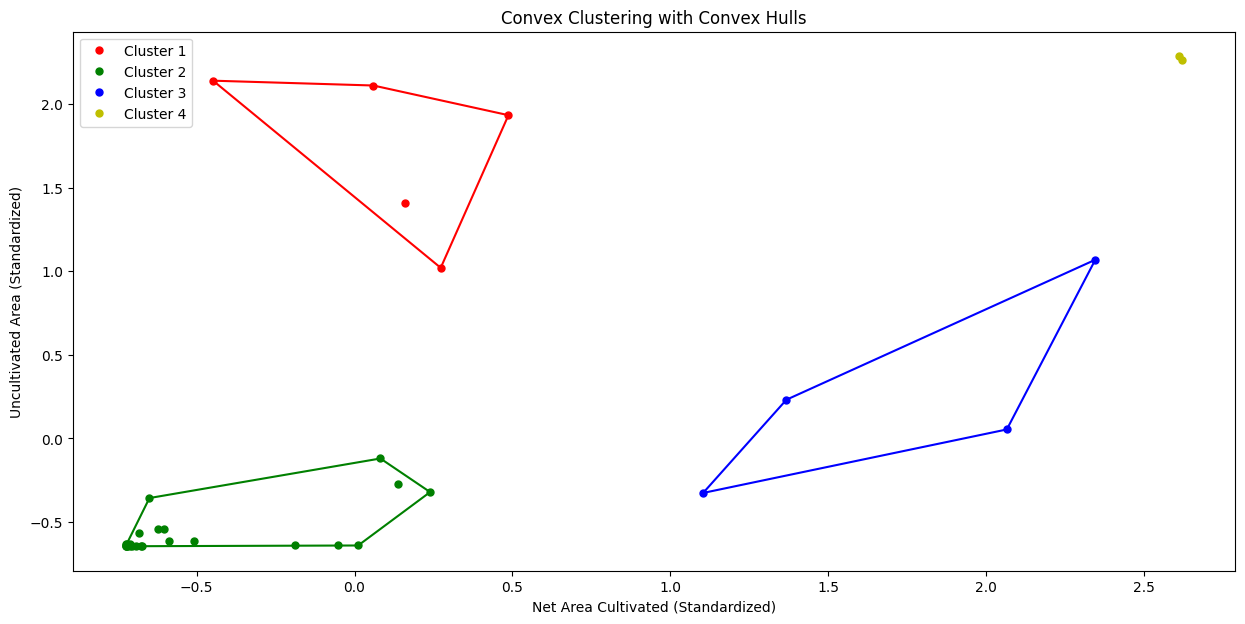

In [ ]:
# Extract clusters and plot convex hulls around them
plt.figure(figsize=(15, 7))
colors = ['r', 'g', 'b', 'y']
for i in range(4):  # Assuming 4 clusters
    points = state_agg_scaled[state_agg['Cluster'] == i, :2]  # Selecting first two dimensions for 2D plot
    if len(points) >= 3:  # ConvexHull requires at least 3 points
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1], colors[i] + '-')  # Plot convex hull edges
    plt.plot(points[:, 0], points[:, 1], 'o', markersize=5, color=colors[i], label=f'Cluster {i+1}')

# Plot settings
plt.title('Convex Clustering with Convex Hulls')
plt.xlabel('Net Area Cultivated (Standardized)')
plt.ylabel('Uncultivated Area (Standardized)')
plt.legend()
plt.show()

# **Choosing the Final Segment**

From the above clustering methods we csee that K- means clustering makes an appropriate sense for choosing the cluster as it has columns for Net Area Sown and Net Area Cultivated whereas Convex clustering creates imbalance for choosing the relevant cluster

**Reason for Choosing Cluster 2 (green) from the K-means:**

 Points here have higher values for both Net Area Sown and Net Area Cultivated, suggesting larger agricultural areas and potentially more intensive farming.

**Reason for not choosing other clusters:**

Cluster 1 (Red) has low values for both Net Area Sown and Net Area Cultivated, so It cannot be chosen

Cluster 3 (Blue) is somewhat intermediate, with points falling between Cluster 1 and Cluster 2. It might represent regions with mix of best and worst.

Cluster 4 (Yellow) is small cluster that has a distinct pattern
